In [11]:
%%javascript
IPython.load_extensions('chrome_clipboard');

<IPython.core.display.Javascript object>

In [1]:
# verify that the subway data for daily ridership is normally distributed the following
#    1. rain days
#    2. non-rain days

%matplotlib inline
import pandas
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import datetime
import numpy
from ggplot import *

import matplotlib as mpl

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1    #.125

def date_to_weekday(date_str):
    return int(datetime.datetime.strptime(date_str, '%Y-%m-%d').strftime('%w'))
    

In [2]:
def get_subway_data(rain=False, sample_size=0):
    """
    parameters:
        rain: True for rain, No for no rain
        sample_size: 0 means everything
    """
    master_data = pandas.read_csv('turnstile_data_master_with_weather.csv')
    
    data = None
    
    if rain:
        data = master_data.query('rain == 1')
    else:
        data = master_data.query('rain == 0')
    
    if sample_size:
        rows = np.random.choice(data.index.values, 1000)
        data = data.ix[rows]
    
    return data

is rain day population normal distributed:	no
is non-rain day population normal distributed:	no


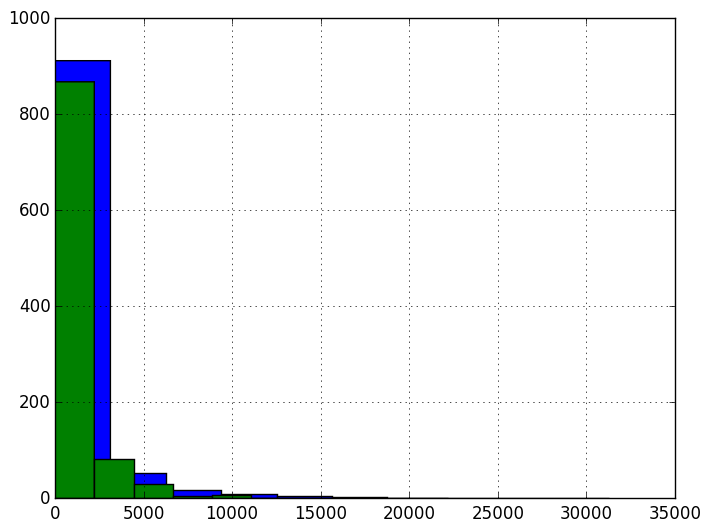

In [3]:
def test_for_normal_distribution():
    """
    this function will perform the following:
        1. load the master subway data with weather
        2. extracted raining day into group a
        3. extracted non-raining day into group b
        4. perform normal distrubtion test
        5. show plot
    """
#     master_data = pandas.read_csv('turnstile_data_master_with_weather.csv')
    
#     rain = master_data.query('rain == 1')
#     no_rain = master_data.query('rain == 0')
    
#     # sampling
#     rows = np.random.choice(rain.index.values, 1000)
#     rain = rain.ix[rows]
#     rows = np.random.choice(no_rain.index.values, 1000)
#     no_rain = no_rain.ix[rows]
    
    rain = get_subway_data(rain=True, sample_size=1000)
    no_rain = get_subway_data(rain=False, sample_size=1000)
    
    # show the histgram
    plt.figure()
    rain['ENTRIESn_hourly'].hist()
    no_rain['ENTRIESn_hourly'].hist()
    
    def shapiro(data):
        w, p = scipy.stats.shapiro(data)
        if p < 0.05:
            return False
        else:
            return True
        
    is_rain_normal_dist = ('yes' if shapiro(rain['ENTRIESn_hourly']) else 'no')
    is_no_rain_normal_dist = ('yes' if shapiro(no_rain['ENTRIESn_hourly']) else 'no')
    
    print 'is rain day population normal distributed:\t' + is_rain_normal_dist
    print 'is non-rain day population normal distributed:\t' + is_no_rain_normal_dist
    
test_for_normal_distribution()

In [4]:
def does_rain_change_ridership():
    """
    this method perform the following:
        1. test to see if rain would introduce statistical differences in subway ridership(ENTRIESn_hourly)
        2. so we can know if our hypothesis that rain affects ridership warrants further investigation or not 
        3. Mann-Whitney U test will be used since subway data is not normal distributed 
    """
    rain = get_subway_data(rain=True)
    no_rain = get_subway_data(rain=False)
    
    print 'stats on rain days'
    print rain.describe()['ENTRIESn_hourly']
    print
    print 'stats on no rain days'
    print no_rain.describe()['ENTRIESn_hourly']
    
    u, p = scipy.stats.mannwhitneyu(rain['ENTRIESn_hourly'], no_rain['ENTRIESn_hourly'])
    
    print 'u: {0} p: {1}'.format(u, p)
    
    if p < 0.05:
        print 'rain does introduce statistical differences in subway ridership'
    else:
        print 'rain does not make a difference in subway ridership'
    
    
does_rain_change_ridership()  

stats on rain days
count    44104.000000
mean      1105.446377
std       2370.527674
min          0.000000
25%         41.000000
50%        282.000000
75%       1103.250000
max      51839.000000
Name: ENTRIESn_hourly, dtype: float64

stats on no rain days
count    87847.000000
mean      1090.278780
std       2320.004938
min          0.000000
25%         38.000000
50%        278.000000
75%       1111.000000
max      43199.000000
Name: ENTRIESn_hourly, dtype: float64
u: 1924409167.0 p: 0.0193096344138
rain does introduce statistical differences in subway ridership


In [15]:
def normalize_features(df):
    """
    Normalize the features in the data set.
    """
    mu = df.mean()
    sigma = df.std()

    if (sigma == 0).any():
        raise Exception("One or more features had the same value for all samples, and thus could " + \
                         "not be normalized. Please do not include features with only a single value " + \
                         "in your model.")
    df_normalized = (df - df.mean()) / df.std()

    return df_normalized, mu, sigma

def compute_cost(features, values, theta):
    """
    Compute the cost of a list of parameters, theta, given a list of features
    (input data points) and values (output data points).
    """
    m = len(values)
    sum_of_square_errors = numpy.square(numpy.dot(features, theta) - values).sum()
    cost = sum_of_square_errors / (2*m)

    return cost

def gradient_descent(features, values, theta, alpha, num_iterations):
    """
    Perform gradient descent given a data set with an arbitrary number of features.

    This can be the same gradient descent code as in the lesson #3 exercises,
    but feel free to implement your own.
    """

    m = len(values)
    cost_history = []

    for i in range(num_iterations):
        # update theta
        y_predict = numpy.dot(features, theta)  # [1 x N] matrix
        theta = theta + (alpha / m) * numpy.dot((values - y_predict), features)

        cost = compute_cost(features, values, theta)
        cost_history.append(cost)

    return theta, pandas.Series(cost_history)

def plot_cost_history(alpha, cost_history):
    """
    This function is for viewing the plot of your cost history.
    You can run it by uncommenting this

       plot_cost_history(alpha, cost_history) 

    call in predictions.

    If you want to run this locally, you should print the return value
    from this function.
    """
    cost_df = pandas.DataFrame({
      'Cost_History': cost_history,
      'Iteration': range(len(cost_history))
    })

    return ggplot(cost_df, aes('Iteration', 'Cost_History')) + \
      geom_point() + ggtitle('Cost History for alpha = %.3f' % alpha )

def compute_r_squared(data, predictions):
    # Write a function that, given two input numpy arrays, 'data', and 'predictions,'
    # returns the coefficient of determination, R^2, for the model that produced
    # predictions.
    #
    # Numpy has a couple of functions -- np.mean() and np.sum() --
    # that you might find useful, but you don't have to use them.

    # YOUR CODE GOES HERE
    avg_of_data = np.mean(data)

    # print 'data: {0}'.format(data)                  # [x1,x2,x3....]
    # print 'prediction: {0}'.format(predictions)     # [x1,x2,x3....]
    # print 'avg of data: {0}'.format(avg_of_data)    # a number

    top = np.square(data - predictions).sum()
    bot = np.square(data - avg_of_data).sum()
    r_squared = 1 - top / bot

    return r_squared

def predict_subway_ridership():
    """
    plan of execuition:
        1. prepare input data
        2. decide what features to use
        3. perform linear regression
        4. assess the performance of prediction
    """
    
    # prepare data
    dataframe = pandas.read_csv('turnstile_data_master_with_weather.csv')
    dataframe['weekday'] = dataframe['DATEn'].apply(lambda d: date_to_weekday(d))
    # dataframe = dataframe.query('weekday != 0 & weekday != 6')
    
    # configure features 
    # 'weekday', 'rain', 'Hour', 'fog', 'meantempi', 'meanpressurei', 'meandewpti'
    f_core = ['weekday', 'rain', 'Hour']
    f_extra_1 = ['fog', 'precipi']
    f_extra_2 = ['meandewpti','meanpressurei', 'meanwindspdi', 'meantempi']
    f_extra_3 = ['maxpressurei','maxdewpti','mindewpti','minpressurei','mintempi','maxtempi']
    f = f_core
    features = dataframe[f]
    """
    ,UNIT,DATEn,TIMEn,Hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,
    maxdewpti,mindewpti, minpressurei,meandewpti,meanpressurei,fog,rain,
    meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
    """
    
    # Add UNIT to features using dummy variables
    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)

    # Values
    values = dataframe['ENTRIESn_hourly']
    m = len(values)

    features, mu, sigma = normalize_features(features)
    features['ones'] = np.ones(m) # Add a column of 1s (y intercept)

    # Convert features and values to numpy arrays
    features_array = np.array(features)
    values_array = np.array(values)

    # Set values for alpha, number of iterations.
    alpha = 0.1 # please feel free to change this value
    num_iterations = 75 # please feel free to change this value

    # Initialize theta, perform gradient descent
    theta_gradient_descent = np.zeros(len(features.columns))
    theta_gradient_descent, cost_history = gradient_descent(features_array,
                                                            values_array,
                                                            theta_gradient_descent,
                                                            alpha,
                                                            num_iterations)


    predictions = np.dot(features_array, theta_gradient_descent)
    
    plot = plot_cost_history(alpha, cost_history)
    
    r_square = compute_r_squared(dataframe['ENTRIESn_hourly'], predictions)
    # 0.4591318085482432  -> 'weekday', 'rain', 'Hour'
    # 0.45942790875846085 -> 'weekday', 'rain', 'Hour', 'fog'
    # 0.46031908653462195 -> 'weekday', 'rain', 'Hour', 'fog', 'meantempi', 'meanpressurei', 'meandewpti'
    # 0.46030533079503744 -> 'weekday', 'rain', 'Hour', 'fog', 'meantempi'
    # 0.46030813587731478 -> 'weekday', 'rain', 'Hour', 'fog', 'meandewpti', 'meantempi'
    # 0.462248971715 -> core + extra1 + extra2
    # 0.461301156449 -> core + extra1
    
    print 'theta is:'
    for i in range(len(f)):
        print '{0}: {1}'.format(f[i], theta_gradient_descent[i])
    print 'r_square is: {0}'.format(r_square)
    
    # return plot
    
predict_subway_ridership()

theta is:
weekday: 92.9091583928
rain: 15.7852837887
Hour: 464.029152408
r_square is: 0.459131808548


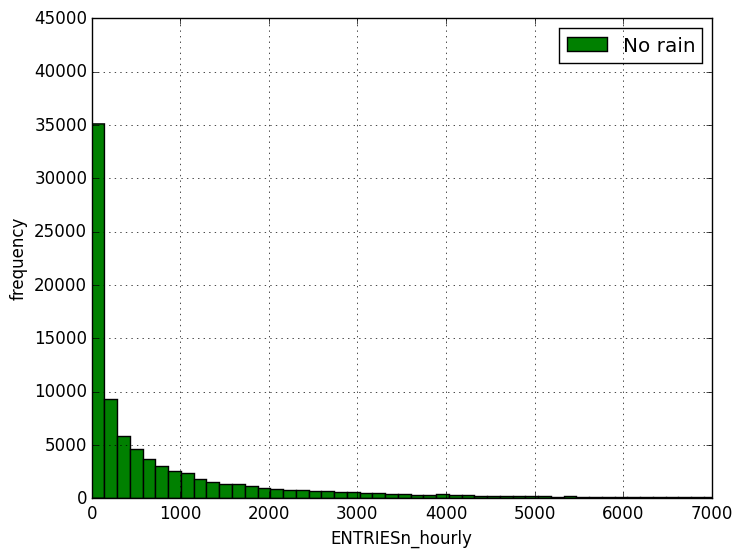

In [6]:
def histogram_no_rain():
    turnstile_weather = pandas.read_csv('turnstile_data_master_with_weather.csv')
    no_rain = turnstile_weather.query('rain == 0')
    
    plt.figure()
    plt.xlim([0,7000])
    plt.ylim([0,45000])
    
    no_rain['ENTRIESn_hourly'].hist(label='No rain', bins=300, color = 'g')
    
    plt.xlabel("ENTRIESn_hourly")
    plt.ylabel("frequency")
    plt.legend()

histogram_no_rain()

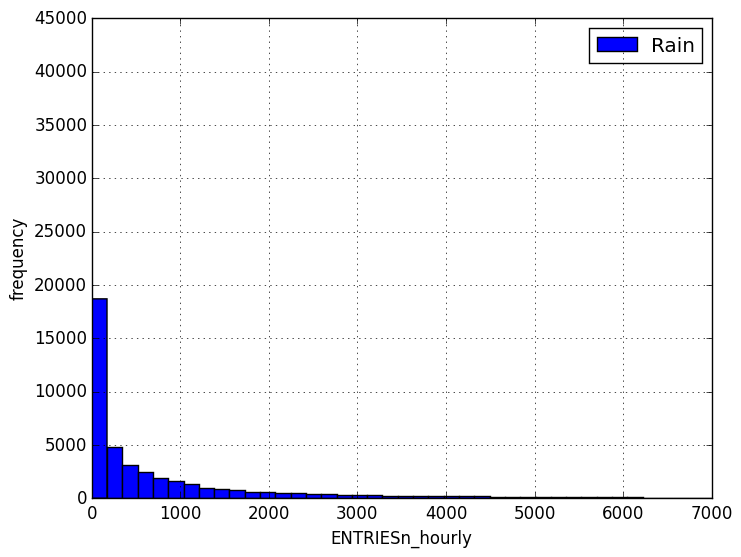

In [7]:
def histogram_rain():
    """
    For the histograms, you should have intervals representing the volume of ridership 
    (value of ENTRIESn_hourly) on the x-axis and the frequency of occurrence on the y-axis. 
    For example, each interval (along the x-axis), the height of the bar for this interval 
    will represent the number of records (rows in our data) that have ENTRIESn_hourly 
    that falls in this interval.
    
    Remember to increase the number of bins in the histogram (by having larger number of bars). 
    The default bin width is not sufficient to capture the variability in the two samples.
    """
    
    turnstile_weather = pandas.read_csv('turnstile_data_master_with_weather.csv')
    rain = turnstile_weather.query('rain == 1')
    
    plt.figure()
    plt.xlim([0,7000])
    plt.ylim([0,45000])
    
    rain['ENTRIESn_hourly'].hist(label='Rain', bins=300, color = 'b')
    
    plt.xlabel("ENTRIESn_hourly")
    plt.ylabel("frequency")
    plt.legend()

histogram_rain()

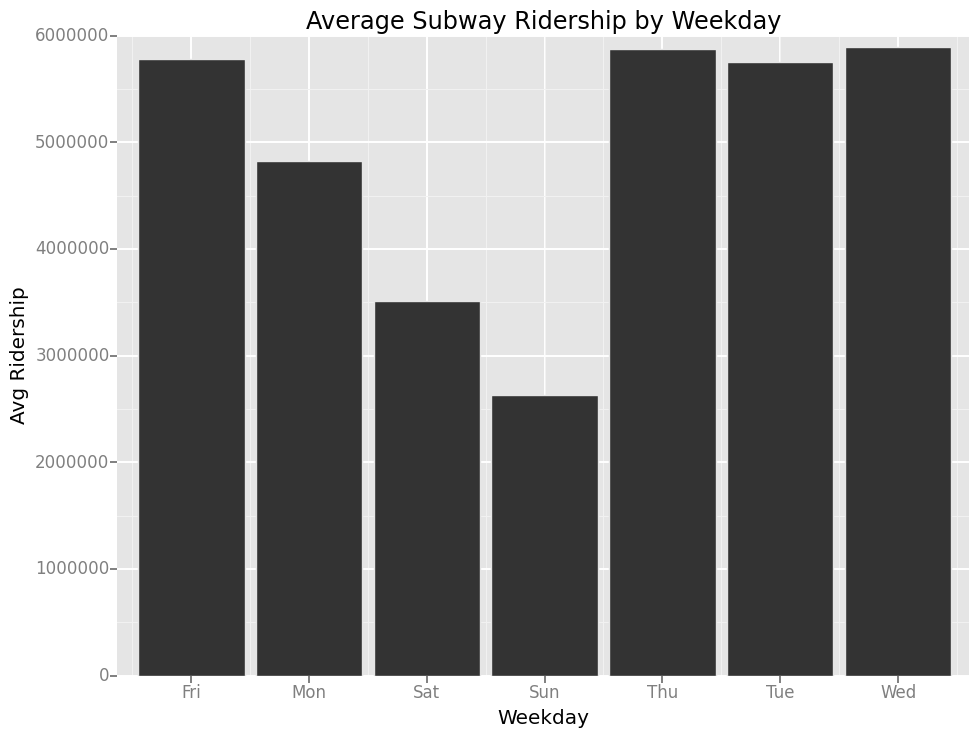

<ggplot: (29657064)>

In [42]:
def ridership_by_day_of_week():
    """
    ridership by day of week
    """
    
    turnstile_weather = pandas.read_csv('turnstile_data_master_with_weather.csv')
    
    by_date = turnstile_weather.groupby(['DATEn'], as_index=False).aggregate(np.sum)
    by_date['week_day'] = by_date['DATEn'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').strftime('%a'))
    by_week_day = by_date.groupby(['week_day'], as_index=False).aggregate(np.average)
    plot = ggplot(aes(x='week_day', y='ENTRIESn_hourly'), data=by_week_day)
    plot = plot + geom_bar(stat="identity")
    plot = plot + ggtitle('Average Subway Ridership by Weekday') + xlab('Weekday') + ylab('Avg Ridership')
    
    return plot

ridership_by_day_of_week()

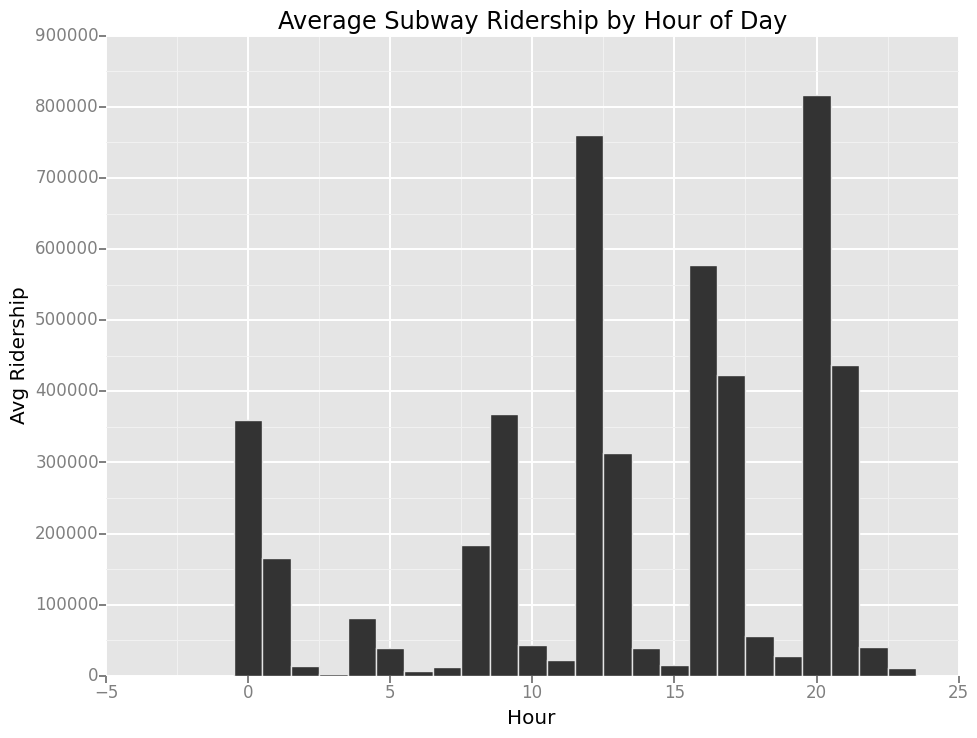

<ggplot: (37541997)>

In [43]:
def ridership_by_hour_of_day():
    """
    the average ridership by hour of day
    """
    
    turnstile_weather = pandas.read_csv('turnstile_data_master_with_weather.csv')
    
    by_hour_day = turnstile_weather.groupby(['Hour'], as_index=False).aggregate(np.sum)
    by_hour_day['ENTRIESn_hourly'] = by_hour_day['ENTRIESn_hourly'] / turnstile_weather['DATEn'].nunique()
    plot = ggplot(aes(x='Hour', y='ENTRIESn_hourly'), data=by_hour_day)
    plot = plot + geom_bar(stat="identity")
    plot = plot + ggtitle('Average Subway Ridership by Hour of Day') + xlab('Hour') + ylab('Avg Ridership')
    return plot

ridership_by_hour_of_day()

In [8]:
from ggplot import *
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from IPython.display import Image

In [11]:
turnstile = pd.read_csv("turnstile_data_master_with_weather.csv", parse_dates=['DATEn'])

In [12]:
turnstile.columns

Index([u'Unnamed: 0', u'UNIT', u'DATEn', u'TIMEn', u'Hour', u'DESCn',
       u'ENTRIESn_hourly', u'EXITSn_hourly', u'maxpressurei', u'maxdewpti',
       u'mindewpti', u'minpressurei', u'meandewpti', u'meanpressurei', u'fog',
       u'rain', u'meanwindspdi', u'mintempi', u'meantempi', u'maxtempi',
       u'precipi', u'thunder'],
      dtype='object')

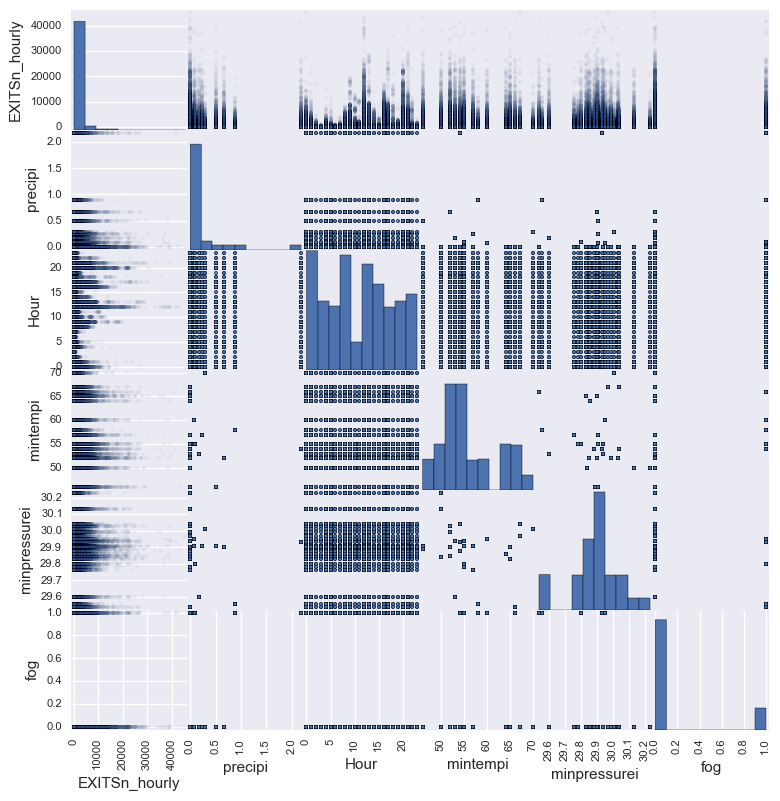

In [15]:
turnstile_sub = turnstile[["EXITSn_hourly","precipi","Hour","mintempi","UNIT","DATEn","minpressurei","fog"]]
a = pd.scatter_matrix(turnstile_sub,alpha=0.05,figsize=(9,9), diagonal='hist')

        rain  precipi  meantempi  unit_R001  unit_R002  unit_R003  unit_R004  \
0          0     0.00         60          1          0          0          0   
1          0     0.00         60          1          0          0          0   
2          0     0.00         60          1          0          0          0   
3          0     0.00         60          1          0          0          0   
4          0     0.00         60          1          0          0          0   
5          0     0.00         60          1          0          0          0   
6          0     0.00         60          0          1          0          0   
7          0     0.00         60          0          1          0          0   
8          0     0.00         60          0          1          0          0   
9          0     0.00         60          0          1          0          0   
10         0     0.00         60          0          1          0          0   
11         0     0.00         60        

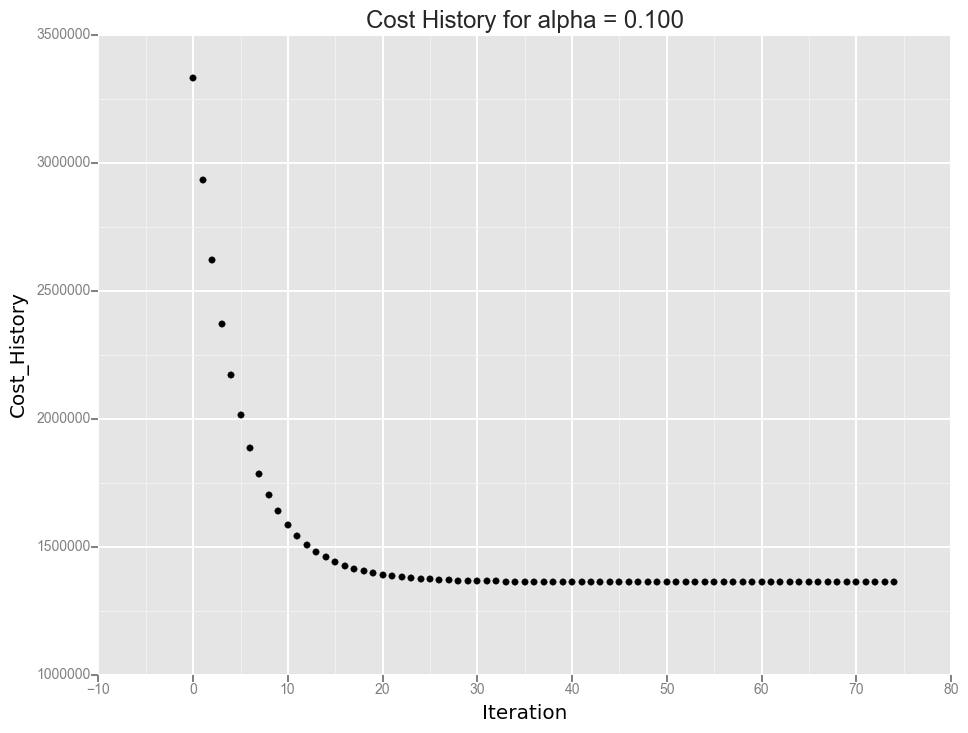

<ggplot: (36226859)>


In [14]:
import numpy as np
import pandas
from ggplot import *




def normalize_features(df):
    """
    Normalize the features in the data set.
    """
    mu = df.mean()
    sigma = df.std()
    
    if (sigma == 0).any():
        raise Exception("One or more features had the same value for all samples, and thus could " + \
                         "not be normalized. Please do not include features with only a single value " + \
                         "in your model.")
    df_normalized = (df - df.mean()) / df.std()

    return df_normalized, mu, sigma


def compute_cost(features, values, theta):
    pred = np.dot(features,theta) 
    error = np.subtract(pred, values)
    cost = (np.square(error)/(2*len(values))).sum()
    return cost

def gradient_descent(features, values, theta, alpha, num_iterations):
    m = len(values)
    cost_history = []
    for i in range(num_iterations):
        # your code here
        predict = np.dot(features,theta)
        error = np.subtract(predict,values)
        a = np.dot(error,alpha)
        grad  = np.dot(a/m,features)
        cost_history.append(compute_cost(features,values,theta))
        theta = np.subtract(theta,grad)
    
    #print "theta: " , theta
    return theta, pandas.Series(cost_history)


def predictions(dataframe):
    # Select Features (try different features!)
    #print "dataframe",dataframe
    features = dataframe[['rain', 'precipi', 'meantempi']]
    
    # Add UNIT to features using dummy variables
    unit_dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')

    # Add another set of dummy variables for time of day and station
    hour_dummy_units = pandas.get_dummies(dataframe['Hour'],prefix='hour')
    #station_dummy_units = pandas.get_dummies(dataframe['station'],prefix='station')
    #conds_dummy_units = pandas.get_dummies(dataframe['conds'],prefix='conds')    

    features = features.join(unit_dummy_units)
    features = features.join(hour_dummy_units)
    #features = features.join(conds_dummy_units)
    #features = features.join(station_dummy_units)
    
    print features
    # Values
    values = dataframe['ENTRIESn_hourly']
    m = len(values)

    features, mu, sigma = normalize_features(features)
    features['ones'] = np.ones(m) # Add a column of 1s (y intercept)
    
    # Convert features and values to numpy arrays
    features_array = np.array(features)
    values_array = np.array(values)

    # Set values for alpha, number of iterations.
    alpha = 0.1 # please feel free to change this value
    num_iterations = 75 # please feel free to change this value

    # Initialize theta, perform gradient descent
    theta_gradient_descent = np.zeros(len(features.columns))
    #print len(features.columns)
    #print len(theta_gradient_descent)
    theta_gradient_descent, cost_history = gradient_descent(features_array, 
                                                            values_array, 
                                                            theta_gradient_descent, 
                                                            alpha, 
                                                            num_iterations)
    ## Compute rsquared...
    rsquared = compute_r_squared(values_array,np.dot(features_array,theta_gradient_descent))


    plot = None
    # -------------------------------------------------
    # Uncomment the next line to see your cost history
    # -------------------------------------------------
    plot = plot_cost_history(alpha, cost_history)
    # 
    # Please note, there is a possibility that plotting
    # this in addition to your calculation will exceed 
    # the 30 second limit on the compute servers.
    
    predictions = np.dot(features_array, theta_gradient_descent)
    #print plot
    return predictions, plot,rsquared


def plot_cost_history(alpha, cost_history):
   cost_df = pandas.DataFrame({
      'Cost_History': cost_history,
      'Iteration': range(len(cost_history))
   })
   return ggplot(cost_df, aes('Iteration', 'Cost_History')) + \
      geom_point() + ggtitle('Cost History for alpha = %.3f' % alpha )

def compute_r_squared(data, predictions):
    N = len(data)
    mu = np.mean(data)
    A = np.subtract(mu,data)
    B = np.square(A)
    SS_tot = np.sum(B)
    SS_res = np.sum(np.square(np.subtract(data,predictions)))
    r_squared = 1-(SS_res/(SS_tot))
    return r_squared

#filepath = '../turnstile_weather_v2.csv'
df = pandas.read_csv('turnstile_data_master_with_weather.csv')

predictions,plot,rsquared = predictions(df)
print "rsquared:", rsquared
print plot